In [2]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=f6f2f1807666e5ea800acf56e9df03a03d939e2a808f355b1728e7829149ec1b
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


## 1) Libraries

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import numpy as np
import pandas as pd
import scipy.sparse as sp
from collections import Counter
from numpy.linalg import norm
import nltk
import re
import spacy
import wikipedia
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
import re
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

## 2) Function to fetch data from Wikipedia

In [4]:
def generate_document(title):
    try:
        page = wikipedia.page(title)
        return page.content.split('\n')
    except wikipedia.exceptions.PageError:
        print(f"Page '{title}' not found.")
        return []
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Page '{title}' is a disambiguation page.")
        return []

In [5]:
# Title of the Wikipedia page you want to generate documents for
title = "(Python)"

# Generate the content of the Wikipedia page as a list
document = generate_document(title)

# Print the content
print(document)

['Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation.', 'Python is dynamically typed and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.', 'Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released it in 1991 as Python 0.9.0. Python 2.0 was released in 2000. Python 3.0, released in 2008, was a major revision not completely backward-compatible with earlier versions. Python 2.7.18, released in 2020, was the last release of Python 2.', 'Python consistently ranks as one of the most popular programming languages, and has gained widespread use in the machine learning community.', '', '', '== History ==', '', 'Python was inv

In [5]:
# doc_1=documents.get("Python (programming language)") 
# doc_2=documents.get("History of Python")
# doc_3=documents.get("Mojo (programming language)")

# documents = [doc_1, doc_2, doc_3]

## 3) Preprocessing

In [6]:
def clean_text(document):
   # Process the text using spaCy
    doc = nlp(document)
    # Extract lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    # Join the lemmatized tokens into a sentence
    cleaned_doc = ' '.join(lemmatized_tokens)
    cleaned_doc = cleaned_doc.lower()
    # Remove links and emails
    cleaned_doc = re.sub(r'http\S+|www\S+|[\w\.-]+@[\w\.-]+', '', cleaned_doc)
    # Remove any thing except words, numbers, and space
    cleaned_doc = re.sub(r'[^\w\s]', '', cleaned_doc)
    # Remove numbers
    cleaned_doc = re.sub(r'[0-9]', '', cleaned_doc)
    # Remove emojis and non ascii characters
    cleaned_doc = re.sub(r'[^\x00-\x7F]+', '', cleaned_doc)
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    cleaned_doc = ' '.join([word for word in cleaned_doc.split() if word not in stop_words])
    cleaned_doc = ' '.join([word for word in cleaned_doc.split() if (len(word) > 1 or word == 'i')])
    return cleaned_doc

In [7]:
clean_document = [clean_text(doc) for doc in document]

## 4) Character-level-based-preprocessing

In [8]:
# Tokenize characters instead of words
tokenizer = Tokenizer(char_level=True)  # Tokenize at character level
tokenizer.fit_on_texts(clean_document)

# convert text to sequence of integers
sequences = tokenizer.texts_to_sequences(clean_document)

In [9]:
# Generate input-output pairs
X = []
y = []
for sequence in sequences:
    for i in range(1, len(sequence)):
        X.append(sequence[:i])
        y.append(sequence[i])

In [10]:
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(X, maxlen=max_sequence_length)
y = np.array(y)

In [11]:
max_sequence_length,X.shape,y.shape

(668, (29289, 668), (29289,))

## 5) Character-level-based-Model

In [12]:
# Model Definitions
vocab_size = len(tokenizer.word_index) + 1 # 29
embedding_dim = 100
rnn_units = 100 

#### RNN: Prediction based on sequence of samples (each sample dependent on the previous state one) instead of one sample.

In [13]:
Char_model = Sequential()
Char_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
Char_model.add(SimpleRNN(units=rnn_units))
Char_model.add(Dense(units=vocab_size, activation='softmax'))
Char_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
history_1 = Char_model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10
  2/916 ━━━━━━━━━━━━━━━━━━━━ 1:00 66ms/step - accuracy: 0.0547 - loss: 3.3704

I0000 00:00:1715523015.689193     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


916/916 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.2163 - loss: 2.6774
Epoch 2/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.3844 - loss: 2.0804
Epoch 3/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.4439 - loss: 1.8895
Epoch 4/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.4784 - loss: 1.7766
Epoch 5/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.5169 - loss: 1.6597
Epoch 6/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.5348 - loss: 1.5840
Epoch 7/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.5526 - loss: 1.5373
Epoch 8/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.5711 - loss: 1.4612
Epoch 9/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.5835 - loss: 1.4242
Epoch 10/10
916/916 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.5892 - loss: 1.3892


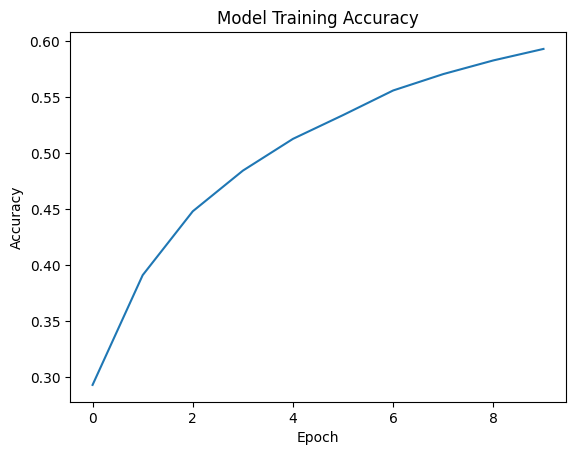

In [15]:
plt.plot(history_1.history['accuracy'])
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 6) Test Char Model

In [19]:
def generate_text_from_data(data, model, tokenizer, max_sequence_length, num_generate=100):
    # Randomly select a sequence from the data
    seed_text = random.choice(data)
    generated_text = seed_text
    for _ in range(num_generate):
        # Tokenize the input string
        input_sequence = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad sequences to match the max_sequence_length
        input_sequence = pad_sequences([input_sequence], maxlen=max_sequence_length)
        # Predict probabilities for the next character
        predicted_probs = model.predict(input_sequence, verbose=0)[0]
        # Sample the next character based on the predicted probabilities
        predicted_index = np.argmax(predicted_probs)
        # Convert the predicted index back to a character
        predicted_char = tokenizer.index_word.get(predicted_index, "")
        # Append the predicted character to the generated text
        generated_text += predicted_char
        # Update the seed text with the predicted character
        seed_text += predicted_char
        # Remove the first character to maintain the fixed length of input_sequence
        seed_text = seed_text[1:]
    return generated_text

for i in range(20):
    generated_text = generate_text_from_data(clean_document, Char_model, tokenizer, max_sequence_length, num_generate=100)
    print(f"Generated Text {i + 1}:\n", generated_text)
    print("-" * 100)

Generated Text 1:
 ruhgfvsprivmvffrtfxfswffrffrftuprvrlovvrgvrsfrflvrjvvbnfvcrsdfvvpffrnjvrpuvlffrdufvpuofwfllrluapjpuv
----------------------------------------------------------------------------------------------------
Generated Text 2:
 answering geospatial reasoning handling semantic web datumace trange siba rolder large object malton riground lindur sem namewry synm progoam colled syit hodo
----------------------------------------------------------------------------------------------------
Generated Text 3:
 python invent late guido van rossum centrum wiskunde informatica cwi netherlands successor abc programming language inspire setl capable exception handling interface amoeba operating system implementation begin december van rossum shoulder sole responsibility project lead developer july announce permanent vacation responsibility python benevolent dictator life bdfl title python community bestow upon reflect long term commitment project chief decision maker since come retiremen

#### The differnce between Word-level and char-level is just input dimension and also max sequence in a model

## 7) Word-level-based-preprocessing 

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_document)

# convert text to sequence of integers
sequences = tokenizer.texts_to_sequences(clean_document)

In [21]:
# Generate input-output pairs
X = []
y = []
for sequence in sequences:
    for i in range(1, len(sequence)):
        X.append(sequence[:i])
        y.append(sequence[i])

In [23]:
# Padding sequences
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(X, maxlen=max_sequence_length)
y = np.array(y)

In [24]:
max_sequence_length,X.shape,y.shape

(89, (3753, 89), (3753,))

## 8) Word Level based model

In [25]:
# Model Definitions
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
rnn_units = 100

In [26]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(SimpleRNN(units=rnn_units))
model.add(Dense(units=vocab_size, activation='softmax'))

In [27]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
history = model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0324 - loss: 6.9951
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0520 - loss: 6.5045
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0477 - loss: 6.3795
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0558 - loss: 6.0819
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0669 - loss: 5.8108
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1011 - loss: 5.4183
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1530 - loss: 5.0425
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2225 - loss: 4.6409
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2932 - loss: 4.2371
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3998 - loss: 3.8170
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4999 - loss: 3.3363
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/st

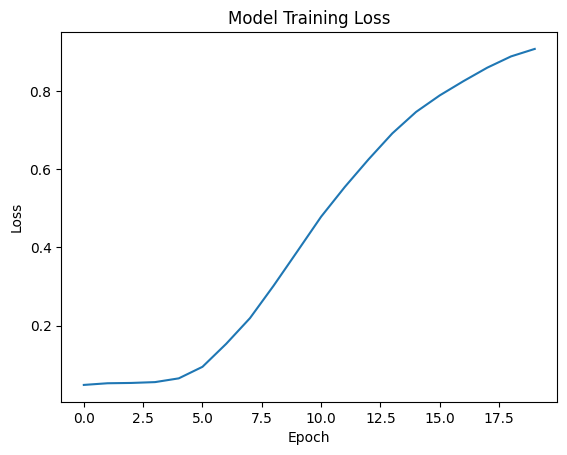

In [25]:
plt.plot(history.history['accuracy'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 9) Test Word Model

In [66]:
def generate_text_from_data(data, model, tokenizer, max_sequence_length, num_generate=50):
    # Randomly select a sequence from the data
    seed_text = random.choice(data)
    generated_text = seed_text
    for _ in range(num_generate):
        # Tokenize the input string
        input_sequence = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad sequences to match the max_sequence_length
        input_sequence = pad_sequences([input_sequence], maxlen=max_sequence_length)
        # Predict probabilities for the next word
        predicted_probs = model.predict(input_sequence, verbose=0)[0]
        # Sample the next word based on the predicted probabilities
        predicted_index = np.argmax(predicted_probs)
        # Convert the predicted index back to a word
        predicted_word = tokenizer.index_word.get(predicted_index, "")
        # Append the predicted word to the generated text
        generated_text += " " + predicted_word
        # Update the seed text with the predicted word
        seed_text += " " + predicted_word
        # Remove the first word to maintain the fixed length of input_sequence
        seed_text = " ".join(seed_text.split()[1:])
    return generated_text

for i in range(5):
    generated_text = generate_text_from_data(clean_document, model, tokenizer, max_sequence_length, num_generate=50)
    print(f"Generated Text {i + 1}:\n", generated_text)
    print("-" * 100)

Generated Text 1:
 groovy motivate desire bring python design philosophy java final python use operator even round tool use call use base may object language exception raise interface ruby instancemethodargument catch critical part version number optimization use decimal division instance document use element class evaluate variable object orient use multiple language call side first class use new feature release python bab
----------------------------------------------------------------------------------------------------
Generated Text 2:
 pyjl compile transpile subset python human readable maintainable high performance julia source code despite claim high performance tool claim arbitrary python code ie know possible compile fast language machine code unless semantic python change many case speedup possible change python code fast julia source code use python compile machine code base way security issue arithmetic operation code instance name type mypy part use like sphinx pdoc fork 

In [36]:
# Define a function to generate predictions for a given input text
def generate_predictions(input_texts, model, tokenizer, max_sequence_length):
    predictions = []
    for input_text in input_texts:
        # Tokenize input text
        input_sequence = tokenizer.texts_to_sequences([input_text])[0]

        # Preprocess the input sequence (pad if necessary)
        input_sequence_padded = pad_sequences([input_sequence], maxlen=max_sequence_length)

        # Predict the next word
        predicted_probs = model.predict(input_sequence_padded)[0]

        # Convert predicted probabilities to word indices
        predicted_char_index = np.argmax(predicted_probs)

        # Convert word index back to word
        predicted_char = tokenizer.index_word.get(predicted_char_index, '<Unknown>')

        predictions.append(predicted_char)

    return predictions

# Example input texts
input_texts = ["python high", "python programming", "unofficial python implementation"]

# Generate predictions for the input texts
predicted_chars = generate_predictions(input_texts, model, tokenizer, max_sequence_length)

for input_text, predicted_char in zip(input_texts, predicted_chars):
    print("Input Text:", input_text)
    print("Predicted Next Word:", predicted_char)
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Input Text: python high
Predicted Next Word: level

Input Text: python programming
Predicted Next Word: language

Input Text: unofficial python implementation
Predicted Next Word: include



## 10) Another model with some RNN layers

In [27]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_2.add(SimpleRNN(units=rnn_units,return_sequences=True))
model_2.add(SimpleRNN(units=rnn_units,return_sequences=True))
model_2.add(SimpleRNN(units=rnn_units))
model_2.add(Dense(units=vocab_size, activation='softmax'))

In [28]:
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
history_2 = model_2.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3937 - loss: 3.4419
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4323 - loss: 3.2279
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5004 - loss: 3.0168
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5426 - loss: 2.7717
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6038 - loss: 2.5377
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6437 - loss: 2.3471
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6853 - loss: 2.1223
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7193 - loss: 1.9440
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7611 - loss: 1.7482
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7852 - loss: 1.6101
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8066 - loss: 1.4626
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 

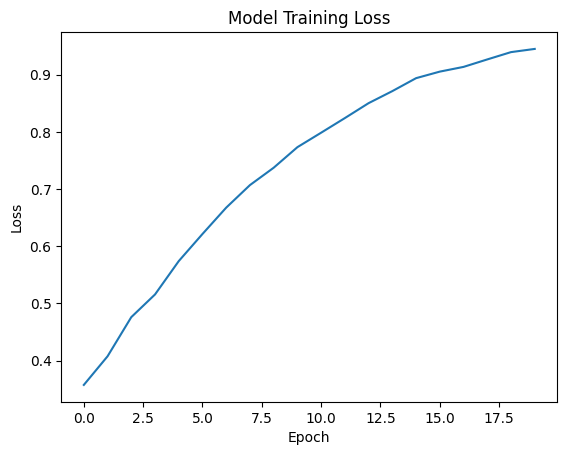

In [38]:
plt.plot(history_2.history['accuracy'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()